# Ensemble: variables (over sea-ice)

## Imports & defaults

In [1]:
import libs.local
import libs.plot
import libs.vars
import matplotlib

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'prra_siconc'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = '''total precipitation (solid), rainfall (dashed),\nand snowfall (dashdot) over sea-ice'''
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'
time_series_y_range = (0, 1.5)
time_series_y_range_monthly = (0, 2)
time_series_y_range_regional = (0, 3)
time_series_process = lambda x: x

In [3]:
ensemble_prra_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_prra_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
)
for variable in ensemble_prra_time_series:
    ensemble_prra_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    ensemble_prra_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }


ensemble_pr_time_series = time_series_process(
    libs.local.get_ensemble_series('pr_siconc', experiment)
)
ensemble_pr_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('pr_siconc', experiment, suffix='_smooth')
)


ensemble_prsn_time_series = time_series_process(
    libs.local.get_ensemble_series('prsn_siconc', experiment)
)
ensemble_prsn_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('prsn_siconc', experiment, suffix='_smooth')
)
for variable in ensemble_prsn_time_series:
    ensemble_prsn_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    ensemble_prsn_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }


ensemble_tas_time_series = time_series_process(
    libs.local.get_ensemble_series('tas_siconc', experiment)
)
ensemble_tas_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('tas_siconc', experiment, suffix='_smooth')
)

ensemble_tas_time_series /= 10
ensemble_tas_time_series_smooth /= 10

for variable in ensemble_tas_time_series:
    ensemble_tas_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    ensemble_tas_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    

ensemble_siconc_time_series = time_series_process(
    libs.local.get_ensemble_series('siconc', experiment)
)
ensemble_siconc_time_series /= 1e7
ensemble_siconc_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('siconc', experiment, suffix='_smooth')
)

for variable in ensemble_siconc_time_series:
    ensemble_siconc_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }


ensemble_sithick_time_series = time_series_process(
    libs.local.get_ensemble_series('sithick', experiment)
)

ensemble_sisnthick_time_series = time_series_process(
    libs.local.get_ensemble_series('sisnthick', experiment)
)
ensemble_sisnthick_time_series *= 10

ensemble_simass_time_series = time_series_process(
    libs.local.get_ensemble_series('simass', experiment)
)

time_slices = libs.vars.default_time_slices()

## Time series

### Mean

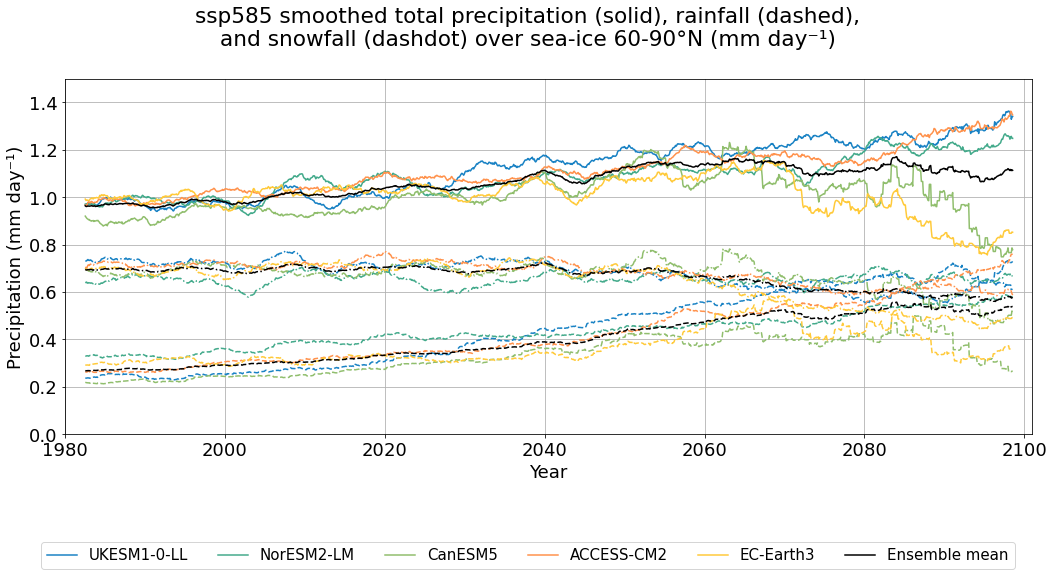

In [4]:
libs.plot.time_series_from_vars(
    [
        ensemble_pr_time_series_smooth,
        ensemble_prsn_time_series_smooth,
        ensemble_prra_time_series_smooth
    ],
    title=f'{experiment} smoothed {time_series_text} 60-90°N ({time_series_units})',
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
)

## Monthly variability

### Full region (time)

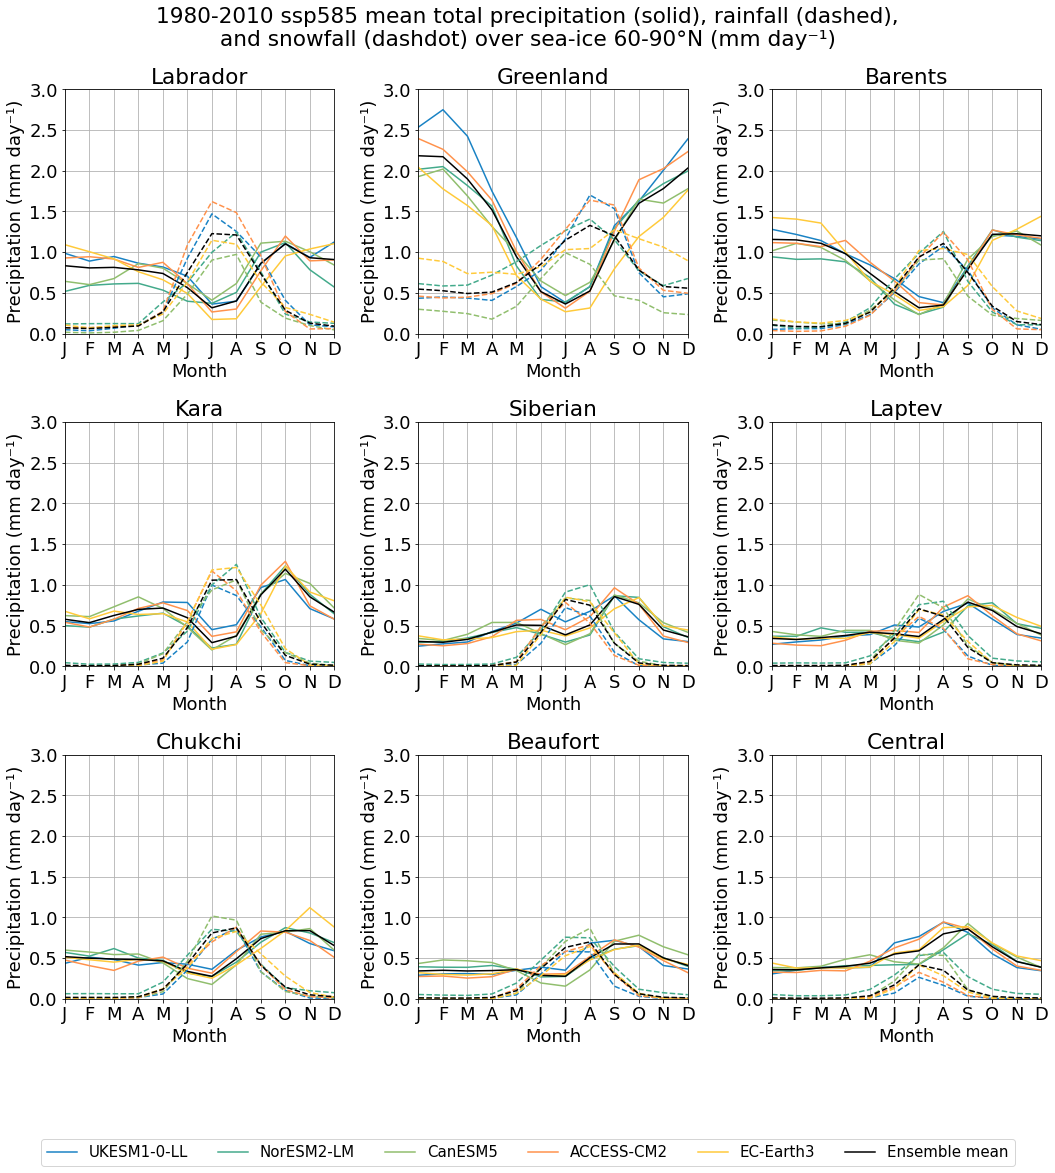

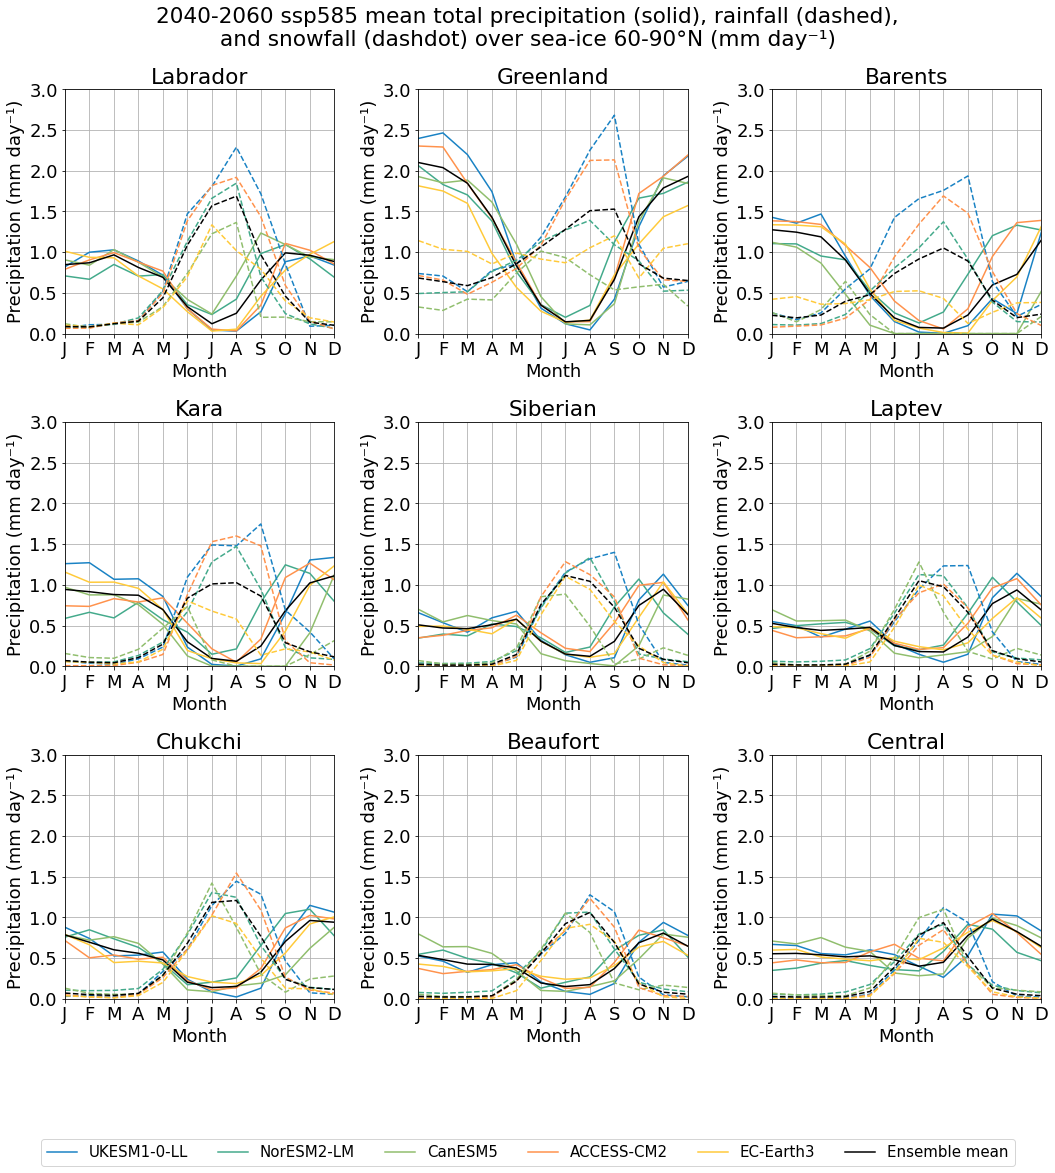

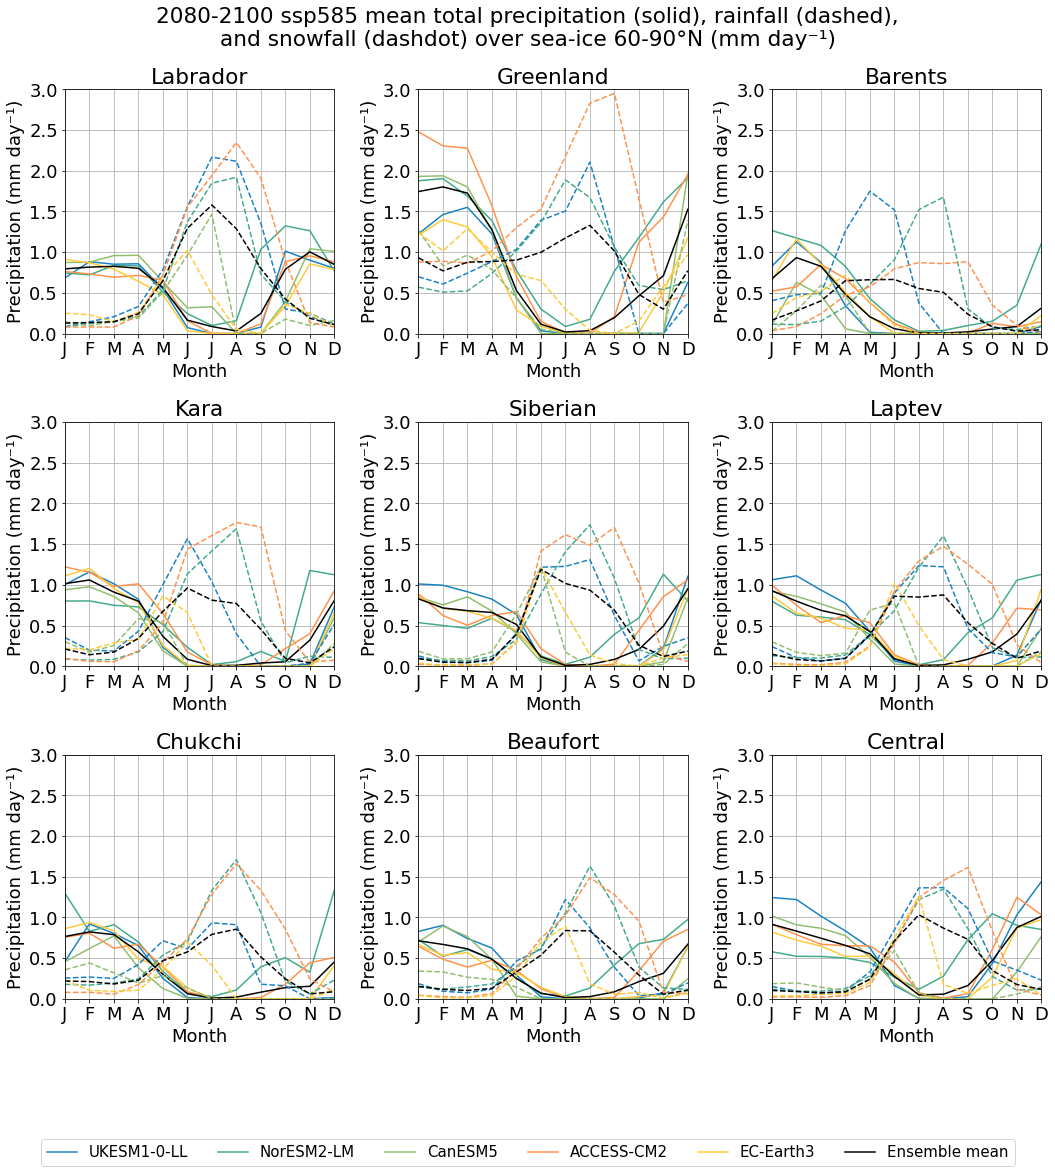

In [5]:
regions_prra = libs.local.get_ensemble_regional_series(variable_id, experiment)
regions_prsn = libs.local.get_ensemble_regional_series('prsn_siconc', experiment)

for s in time_slices:
    s_label = s['label']
    arr = []
    for i, data_prra in enumerate(regions_prra):        
        data_prra_slice = data_prra.sel(**s['slice']).groupby('time.month').mean('time')
        for variable in data_prra_slice:
            data_prra_slice[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

        arr.append([
            regions_prsn[i].sel(**s['slice']).groupby('time.month').mean('time'),
            data_prra_slice,
        ])

    libs.plot.monthly_variability_regional(
        arr,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

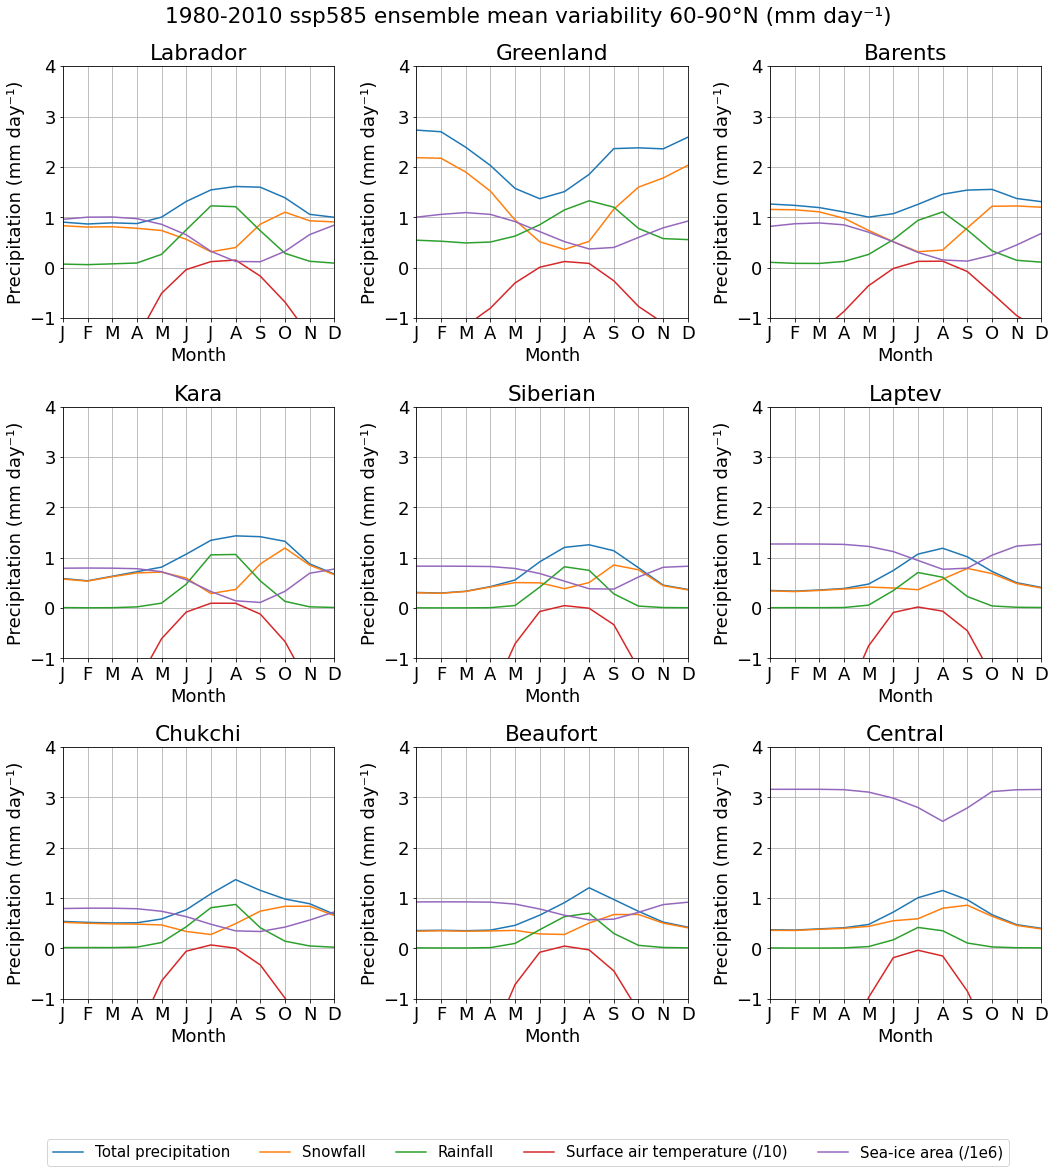

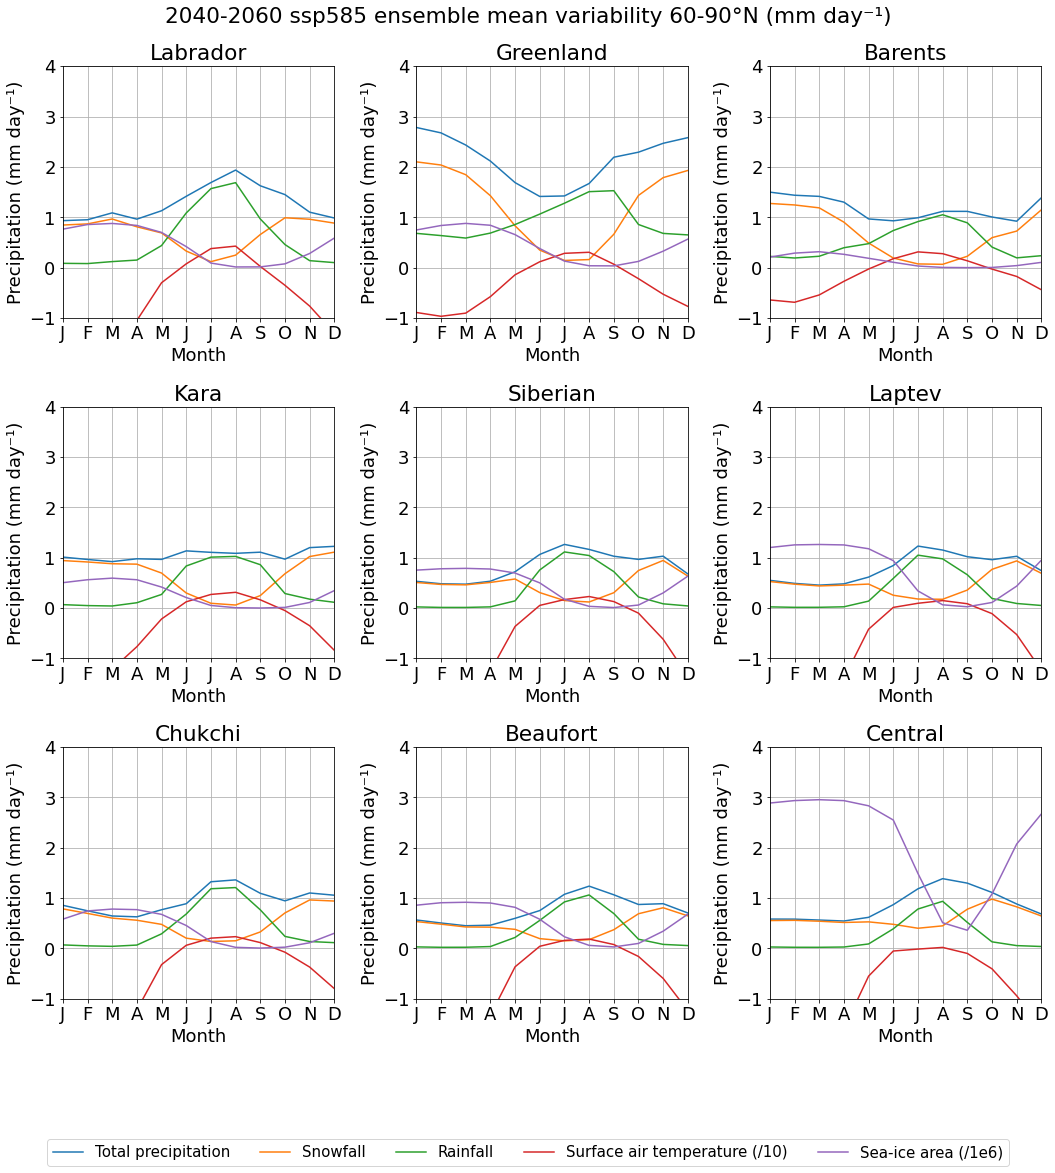

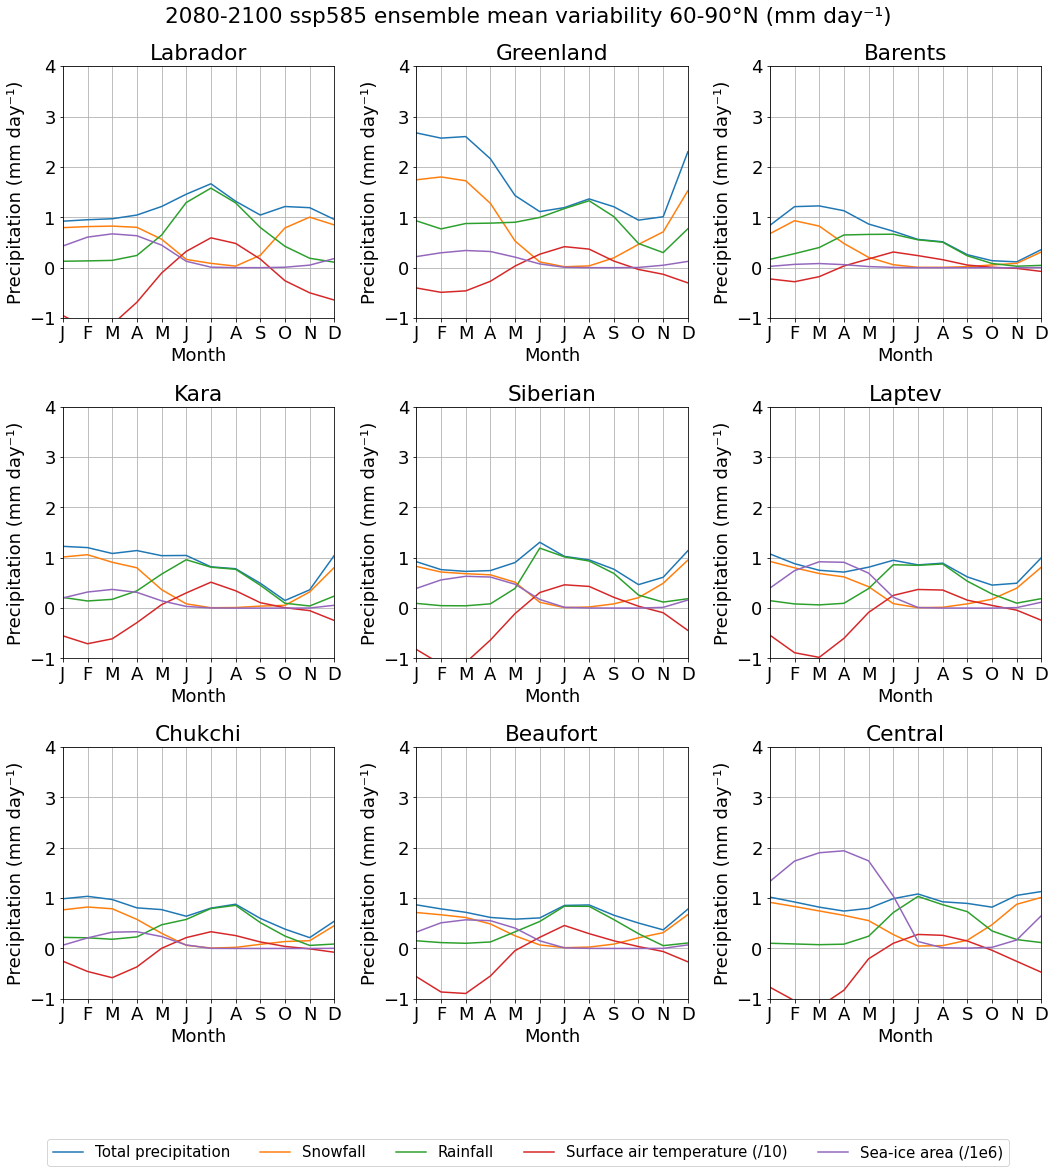

In [6]:
regions_pr = libs.local.get_ensemble_regional_series('pr_siconc', experiment)
regions_prra = libs.local.get_ensemble_regional_series('prra_siconc', experiment)
regions_prsn = libs.local.get_ensemble_regional_series('prsn_siconc', experiment)
regions_tas = libs.local.get_ensemble_regional_series('tas_siconc', experiment)
regions_siconc = libs.local.get_ensemble_regional_series('siconc', experiment)

for s in time_slices:
    s_label = s['label']
    arr = []
    for i, data_prra in enumerate(regions_prra):
        data_pr_slice = regions_pr[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_pr_slice['Ensemble mean'].attrs['label'] = 'Total precipitation'
        del data_pr_slice['Ensemble mean'].attrs['color']
        
        data_prsn_slice = regions_prsn[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_prsn_slice['Ensemble mean'].attrs['label'] = 'Snowfall'
        del data_prsn_slice['Ensemble mean'].attrs['color']
        
        data_prra_slice = data_prra.sel(**s['slice']).groupby('time.month').mean('time')
        data_prra_slice['Ensemble mean'].attrs['label'] = 'Rainfall'
        del data_prra_slice['Ensemble mean'].attrs['color']

        data_siconc_slice = regions_siconc[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_siconc_slice /= 1e6
        data_siconc_slice['Ensemble mean'].attrs['label'] = 'Sea-ice area (/1e6)'
        del data_siconc_slice['Ensemble mean'].attrs['color']

        data_tas_slice = regions_tas[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_tas_slice /= 10
        data_tas_slice['Ensemble mean'].attrs['label'] = 'Surface air temperature (/10)'
        del data_tas_slice['Ensemble mean'].attrs['color']

        arr.append([
            data_pr_slice,
            data_prsn_slice,
            data_prra_slice,
            data_tas_slice,
            data_siconc_slice
        ])

    libs.plot.monthly_variability_regional(
        arr,
        legend_below=True,
        title=f'{s_label} {experiment} ensemble mean variability 60-90°N ({time_series_units})',
        variables=['Ensemble mean'],
        ylabel=time_series_y_label,
        yrange=(-1, 4)
    )